# Домашняя работа №9.3

# Цель и задачи работы:

1) Реализовать алгоритм поиска ключевых точек на основе нейронных сетей;
2) Сравнить результат работы данного алгоритма с алгоритмом поиска ключевых точек при попощи детекторов "SIFT" и "ORB".

# 1. Реализация алгоритма

Для начала, импортируем необходимые библиотеки:

In [36]:
import matplotlib.pyplot as plt;
import cv2;
import kornia as K;
import kornia.feature as KF;
import numpy as np;
import torch;
from kornia_moons.feature import *;

Реализуем функцию "local_descriptor_function()", которая принимает на вход следующие аргументы:
1) "image" - файл изображения; 
2) "key_points" - массив ключевых точек изображения; 
3) "model" - модель определения дескриптора.

In [39]:
def local_descriptor_function(image, key_points, model):
  with torch.no_grad():
    model.eval();
    timg = K.color.rgb_to_grayscale(K.image_to_tensor(image, False).float()) / 255.;
    lafs = laf_from_opencv_SIFT_kpts(key_points);
    affine = KF.LAFAffNetShapeEstimator(True);
    orienter = KF.LAFOrienter(32, angle_detector = KF.OriNet(True));
    orienter.eval();
    affine.eval();
    lafs_new = orienter(affine(lafs, timg), timg);
    patches = KF.extract_patches_from_pyramid(timg, lafs_new, 32);
    B, N, CH, H, W = patches.size();
    descs = model(patches.view(B * N, CH, H, W)).view(B * N, -1);
  return descs.detach().cpu().numpy();

Данная функция реализует метод вычисления дескрипторов для массива ключевых точек при помощи комбинации алгоритмов "AffNet" и "HardNet". "AffNet" - алгоритм для обучения областей, которые ковариантны к матрице афинного преобразования с функцией постоянной отрицательной потери ("hard negative-constant loss"). "HardNet" - обучаемый дескриптор признаков, показавший лучшую эффективность в сравнении с классическими и обучаемыми дескрипторами признаков и который возможно быстро вычислять на "GPU".

Затем реализуем функцию "points_matching_function()", которая принимает на вход следующие аргументы:
1) "image_1" - файл первого изображения; 
2) "image_2" - файл второго изображения;
3) "model" - модель определения дескриптора.

In [43]:
def points_matching_function(image_1, image_2, model):
  image_1 = cv2.cvtColor(cv2.imread(image_1), cv2.COLOR_BGR2RGB);
  image_2 = cv2.cvtColor(cv2.imread(image_2), cv2.COLOR_BGR2RGB);
  detector_type = cv2.SIFT_create(8000);
  key_points_1 = detector_type.detect(image_1, None);
  key_points_2 = detector_type.detect(image_2, None);
  descriptor_1 = local_descriptor_function(image_1, key_points_1, model);
  descriptor_2 = local_descriptor_function(image_2, key_points_2, model);
  dists, idxs = KF.match_smnn(torch.from_numpy(descriptor_1), torch.from_numpy(descriptor_2), 0.95);
  tentatives = cv2_matches_from_kornia(dists, idxs);
  source_points = np.float32([ key_points_1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2);
  destination_points = np.float32([ key_points_2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2);
  F, inliers_mask = cv2.estimateAffine2D(source_points, destination_points);
  draw_params = dict(matchColor = (255,255,0), singlePointColor = None, matchesMask = inliers_mask.ravel().tolist(), flags = 2);
  image_output = cv2.drawMatches(image_1, key_points_1, image_2, key_points_2, tentatives, None, **draw_params);
  plt.figure();
  fig, ax = plt.subplots(figsize = (15, 15));
  ax.imshow(image_output, interpolation = 'nearest');
  print (f'{inliers_mask.sum()} ключевых точек найдено');
  plt.show();

Данная функция выполняет расчет матрицы аффинного преобразования для набора ключевых точек и дексрипторов двух изображений, и выводит результирующее изображение, а также количество найденных совпадений между ключевыми точками двух изображений.

Выполним вычисление общих ключевых точек между двумя изображениями:

/var/folders/72/z0rddslj7wzf385tx9wnqfk00000gn/T/ipykernel_19903/4101555542.py:6: DeprecationWarning: `LAFAffNetShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  affine = KF.LAFAffNetShapeEstimator(True);


138 ключевых точек найдено


<Figure size 640x480 with 0 Axes>

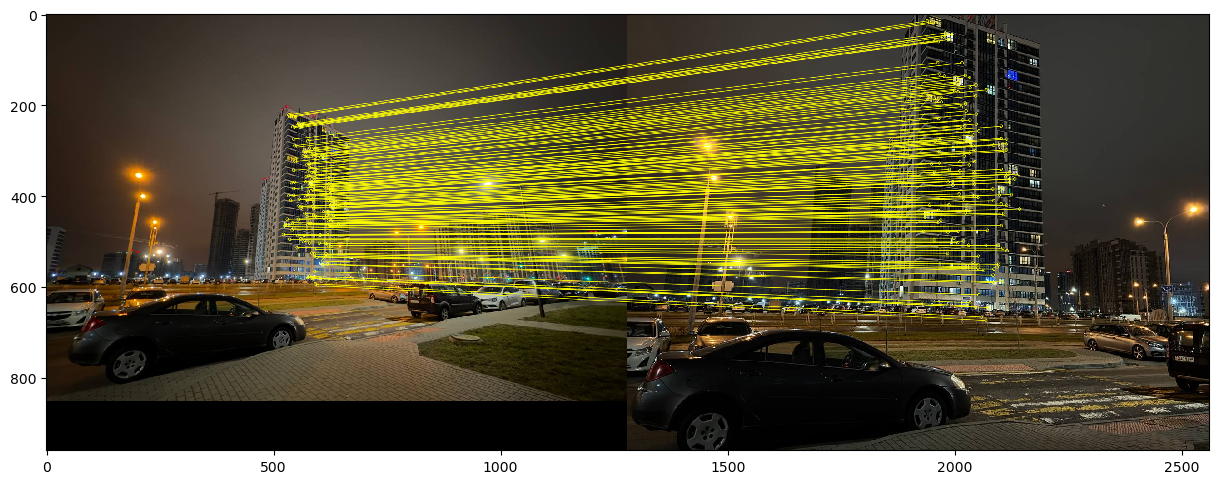

In [48]:
image_1 = 'Image_1.jpeg';
image_2 = 'Image_2.jpeg';
model = KF.HardNet(True);
points_matching_function(image_1, image_2, model);

## 2.Сравнение результата с другими детекторами

Если сравнивать результат вычисления общих ключевых точек между двумя изображениями посредством применения комбинации методов машинного обучения "AffNet + HardNet" и посредством детекторов "SIFT" и "ORB", то мы можем увидеть, что комбинация "AffNet + HardNet" позволяет найти большее количество общих ключевых точек на меньшей области изображения с более высокой точностью. Для сравнения приведем результаты вычисления при помощи детекторов "SIFT" и "ORB".

Результат (детектор "SIFT"):

![image](Combined_matches_image.jpeg)

Результат (детектор "ORB"):

![image](ORB_detector_image.png)

# Выводы

В результате работы были выполнены все цели и задачию. Метод вычисления дескрипторов для массива ключевых точек при помощи комбинации алгоритмов машинного обучения "AffNet" и "HardNet" показал лучшие результаты, чем "классические методы", основанные на применении детекторов "SIFT" и "ORB".